# DataPreparing

THe first step of our notebooks will be to run a DataPreparing script.  
This contains all the necessary code to transform our original images into images that are ready for AI training.  

To benefit from the perks of our Azure cloud service, we will be creating a new dataset to store our processed images.

Follow along in the HackMD documents to answer some questions introduced in these notebooks.

If you want more background information on these notebooks, the HackMD documents will help you as well.

## Setup

Our virtual machine might not have all packages installed yet. So let's go and install some packages.  
We can use cell-magic for this, which will allow us to stay inside this notebook and just executing the cells.  

Later on, these cells might nog be necessary anymore, which is why we include it at the top. During other builds, you can just ignore these.

As a best practice, let's make sure to only work on the version we know is safe. This is a great way to organising our AI projects. By keeping the versions linked like this, no unexpected new version would break our code!

In [1]:
%%writefile requirements.txt

opencv-python==4.5.4.60

Writing requirements.txt


In [2]:
# We want to make sure to use the right AzureML packages!
!/anaconda/envs/azureml_py38_PT_TF/bin/python -m pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 4.9 MB/s eta 0:00:00:00:0100:01


In [3]:
# This cell can be used to fill in some values that you will be referring to in the coming cells
train_test_split_factor = 0.20

In [4]:
# Importing the default packages for data processing and visualisation
import numpy as np # Used to process our images in a data-format
import matplotlib.pyplot as plt # visualise the images
import cv2 # Process the images


import os
from glob import glob
import math

import warnings
warnings.filterwarnings("ignore") # Warnings that can be ignored will be ignored

import random
SEED = 42 # Everytime you want to randomize items, use this `random.seed(SEED)` option. This way, you are always having the same randomization as I have.
random.seed(SEED)

In [5]:
# Import AzureML packages
from azureml.core import Workspace
from azureml.core import Dataset
from azureml.data.datapath import DataPath
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

## Step 1: Connecting to the Azure ML Workspace

Azure Machine Learning needs to connect through the Azure SDK with the Workspace object. This contains all the information inside of this 'Laboratory'

The information below should reflect your situation regarding Azure. You should have a ResourceGroup called '04_AzureML' and a workspace name called 'segersnathan' if you followed my instructions on HackMD.
The subscription ID, however, is something that has been created by Azure itself.

Luckily, this ML studio gives us a quick way to find this information.
Click on the \/-arrow in the upper-right corner over there ↗️, next to your profile picture.

Most of your information is in there as well, but you still can't find your subscription_**id** there ...

Press the 'Download config' option, and you'll be left with this information:

```json
{
    "subscription_id": "7c50f9c3-289b-4ae0-a075-08784b3b9042",
    "resource_group": "NathanReserve",
    "workspace_name": "segersnathan"
}
```

Which gives you exactly the information you need 🥰

There's also an option to use this configuration itself. Search for the documentation on how to do it: https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.workspace(class)?view=azure-ml-py


In [9]:
## Either get environment variables, or a fallback name, which is the second parameter.
## Currently, fill in the fallback values. Later on, we will make sure to work with Environment values. So we're already preparing for it in here!
workspace_name = os.environ.get('WORKSPACE', 'felix-platteau-ml')
subscription_id = os.environ.get('SUBSCRIPTION_ID', '9ae53766-1df1-4559-8ad6-262ddacf26b7')
resource_group = os.environ.get('RESOURCE_GROUP', 'mlops')

In [10]:
ws = Workspace.get(name=workspace_name,
               subscription_id=subscription_id,
               resource_group=resource_group)

In [11]:
ws

Workspace.create(name='felix-platteau-ml', subscription_id='9ae53766-1df1-4559-8ad6-262ddacf26b7', resource_group='mlops')

## Step 2 -- Data preparing

Let's get started preparing our data.
The original dataset contains images of rice, but are not yet ready for AI processing.
They are all different shapes and sizes, so they need to be processed.

I could've done it earlier on and given you the processed data, but that's not really that fun, isn't it 😉

By performing these steps, you see how you can create datasets in a Programmatoric way, and upload new data.
We will make use of the Azure Machine Learning tools to easily manage all of our datasets in a structured way.

## Step 2.1 -- Checking our data

Let us first explore how the data looks. We'll create 3 subdirectories under a data directory, one for each rice.
If you want to update this to more rice later, simply adapt the `RICES` list.

In [12]:
RICES = ['Arborio_v1', 'Basmati_v1', 'Ipsala_v1', 'Jasmine_v1', 'Karacadag_v1'] # As we have three classes, let's just defined them hoor. This way we can easily loop over them later.
# We can also work with ENUM's if you want another fun way of accessing properties:
# Feel free to uncomment these lines, I won't work with them, but you can always do so if yoi prefer


# from enum import Enum
# rice = Enum('rice', 'CATS DOGS PANDAS')

# print(list(rice))
# print(rice.CATS.name.lower()) # You can always get their effective string values this way

We will need to create temporary directories to store the images while we process them.
This script will create a `data` folder, and then make subdirectories for each animal.

In [13]:
data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)
for rice_name in RICES:
    os.makedirs(os.path.join(data_folder, 'rice', rice_name), exist_ok=True)

In [14]:
# Get all the datasets that were registered in the UI
# We can then easily select the ones we need
datasets = Dataset.get_all(workspace=ws) # Make sure to give our workspace with it
print(datasets)

{ 'Arborio_v1': DatasetRegistration(id='23aa2c70-2e22-4f07-aa02-fd8b6f3c10ba', name='Arborio_v1', version=1, description='', tags={}),
  'Basmati_v1': DatasetRegistration(id='d9c164c7-a5a1-4f6d-a050-4e4ff1c2f35a', name='Basmati_v1', version=1, description='', tags={}),
  'Ipsala_v1': DatasetRegistration(id='0bf0349b-ac3b-4459-95ba-e0f6fdc5da38', name='Ipsala_v1', version=1, description='', tags={}),
  'Jasmine_v1': DatasetRegistration(id='67f20d87-a70d-4657-92a9-5a83a0e3711a', name='Jasmine_v1', version=1, description='', tags={}),
  'Karacadag_v1': DatasetRegistration(id='1a7c3105-f8b1-43fd-956d-a1d3b20d4f58', name='Karacadag_v1', version=1, description='', tags={})}


### **TODO for students**

Write a check to see if we have our three datasets!!

In [13]:
# Write your answer here

Uncomment the next cell to show a possible answer

In [15]:
# %load code_solutions/CheckDatasets.txt
def checkDatasets():
    if all(rice in list(datasets.keys()) for rice in RICES):
        print("All datasets are available!")
    else:
        print("Your are missing some datasets.")
checkDatasets()

All datasets are available!


In [16]:
from typing import List
def downloadTestImagesForRice(rice_name: str, amount_of_test_images: int) -> List[str]:
    """
    Download test images from an Azure dataset.
    Choose the amount of test images per rice you want.
    The images will be downloaded to the `data/<rice>` directory

    Parameters:
        rice_name (str): The name of the dataset / rice to download images from
        amount_of_test_images (int): The amount of test images to download
    Returns:
        file_paths (List[str]): list of file paths to display the images
    """
    rice_dataset = datasets[rice_name]
    test_images = rice_dataset.take(amount_of_test_images)
    file_paths = test_images.download(os.path.join(data_folder, 'rice', rice_name), overwrite=True)
    return file_paths

def displayTestImages(images: List[str]) -> None:
    fig, axes = plt.subplots(1, len(images), figsize=(12, 9), sharey=True)
    axes_1d = axes.ravel()
    for i in range(0, len(images)):    
        axes_1d[i].imshow(plt.imread(images[i]), cmap='gray')
        axes_1d[i].axis('off')
        
    plt.show()

Choose a number of images you want to show the users

In [17]:
rice_images = {}
AMOUNT_OF_IMAGES = 5
for rice_name in RICES:
    print(f"Downloading {AMOUNT_OF_IMAGES} images of {rice_name}...")
    rice_images[rice_name] = {}
    rice_images[rice_name]['images'] = downloadTestImagesForRice(rice_name, AMOUNT_OF_IMAGES)
    

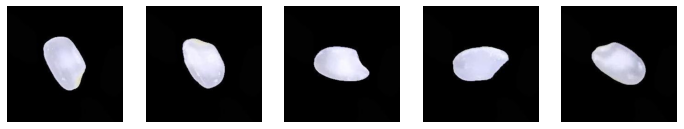

In [18]:
displayTestImages(rice_images['Karacadag_v1']['images'])

### Step 2.2 Processing and uploading the resized images

Like we said in the introduction, we'll need to resize the images so they're all the same shape and size.
We are getting ready for a CNN model, which will require an input of 64, 64. You can go higher, but then it'll take longer to train, but also improve the accuracy.

In [19]:
# Let's create a mounth point. Think of it like your D:/ drive on your PC
# mount_path = os.path.join(os.getcwd(), 'mount')
mount_path = os.path.join('/home/azureuser/cloudfiles/data')
os.makedirs(mount_path, exist_ok=True)

In [20]:
# Defien a path to store the rice images onto. We'll choose for `data/processed/rice` this time. Again, create subdirectories for all the rice
processed_path = os.path.join(mount_path, 'processed', 'rice')
os.makedirs(processed_path, exist_ok=True)
for rice_name in RICES:
    os.makedirs(os.path.join(processed_path, rice_name), exist_ok=True)

In [21]:
# Defien a path to store the rice images onto. We'll choose for `data/processed/rice` this time. Again, create subdirectories for all the rice
original_path = os.path.join(mount_path, 'original', 'rice')
os.makedirs(original_path, exist_ok=True)
for rice_name in RICES:
    os.makedirs(os.path.join(original_path, rice_name), exist_ok=True)

In [22]:
!ls $mount_path
!ls $mount_path/processed/rice
!ls $mount_path/original/rice

original  processed
Arborio_v1  Basmati_v1	Ipsala_v1  Jasmine_v1  Karacadag_v1
Arborio_v1  Basmati_v1	Ipsala_v1  Jasmine_v1  Karacadag_v1


In [23]:
def mountProcessAndUploadRiceImages(rice_name):

    # The mount context is to load in the dataset to our directory.
    # Make sure to stop it when it's finished!

    # Get the dataset name for this rice, then mount to the directory
    mounted_context = datasets[rice_name].mount(os.path.join(mount_path, 'original', 'rice', rice_name))
    print('Starting the Mount context, to get all the original images.')
    mounted_context.start()

    # Get all the image paths with the `glob()` method.
    print(f'Resizing all images for {rice_name} ...')
    imagePaths = glob(f"{mount_path}/original/rice/{rice_name}/*.jpg")

    # Process all the images with OpenCV. Reading them, then resizing them to 64x64 and saving them once more.
    print(f"Processing {len(imagePaths)} images")
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64)) # Resize to a square of 64, 64
        cv2.imwrite(os.path.join(processed_path, rice_name, imagePath.split('/')[-1]), image)
    print(f'... done resizing. Stopping context now...')
    
    # Upload the directory as a new dataset
    print(f'Uploading directory now ...')
    resized_dataset = Dataset.File.upload_directory(
                        # Enter the sourece directory on our machine where the resized pictures are
                        src_dir = os.path.join(processed_path, rice_name),
                        # Create a DataPath reference where to store our images to. We'll use the default datastore for our workspace.
                        target = DataPath(datastore=ws.get_default_datastore(), path_on_datastore=f'processed_rice/{rice_name}'),
                        overwrite=True)
    # Make sure to register the dataset whenever everything is uploaded.
    resized_dataset.register(ws,
                            name=f'resized_{rice_name}',
                            description=f'{rice_name} images resized tot 64, 64',
                            tags={'rice': rice_name, 'AI-Model': 'CNN'}, # Optional tags, can always be interesting to keep track of these!
                            create_new_version=True)
    print(f'... Done')
    # Stop the context now.
    mounted_context.stop()
    print(f"... Context stopped and freed.")

In [24]:
%%time
# Process all the rice images now. This can take a while!
# We'll use Cell magic once more, to time how long this takes!
mountProcessAndUploadRiceImages('Arborio_v1')
mountProcessAndUploadRiceImages('Basmati_v1')
mountProcessAndUploadRiceImages('Ipsala_v1')
mountProcessAndUploadRiceImages('Jasmine_v1')
mountProcessAndUploadRiceImages('Karacadag_v1')

Starting the Mount context, to get all the original images.
Resizing all images for Arborio_v1 ...
Processing 1000 images
... done resizing. Stopping context now...
Uploading directory now ...
Validating arguments.
Arguments validated.
Uploading file to processed_rice/Arborio_v1
Uploading an estimated of 1000 files
Uploading /home/azureuser/cloudfiles/data/processed/rice/Arborio_v1/Arborio_(686).jpg
Uploaded /home/azureuser/cloudfiles/data/processed/rice/Arborio_v1/Arborio_(686).jpg, 1 files out of an estimated total of 1000
Uploading /home/azureuser/cloudfiles/data/processed/rice/Arborio_v1/Arborio_(157).jpg
Uploaded /home/azureuser/cloudfiles/data/processed/rice/Arborio_v1/Arborio_(157).jpg, 2 files out of an estimated total of 1000
Uploading /home/azureuser/cloudfiles/data/processed/rice/Arborio_v1/Arborio_(274).jpg
Uploaded /home/azureuser/cloudfiles/data/processed/rice/Arborio_v1/Arborio_(274).jpg, 3 files out of an estimated total of 1000
Uploading /home/azureuser/cloudfiles/data

Our Animal datasets are now registered onto the datasets of Azure, which is what we need. We can now safely delete all the images from our disk.

### **TODO for students**

Delete the images from disk in any way you want.


In [24]:
# Write your answer here

Uncomment the next cell to see a possible answer.

In [25]:
# %load code_solutions/RemoveProcessedDirectories.txt
# Remove the processed directory
import shutil

for rice_name in RICES:
    shutil.rmtree(os.path.join(processed_path, rice_name), )

## Step 2.3 -- Create Training and Testing splitted data

As you might remember from previous AI lessons, we want to split up our AI data in a batch of Training and Testing data, with the necessary labels.
We will take a portion of our data to train on, and the rest will be kept to test and validate our AI model.

For this, I chose a percentage in the first cell:
`train_test_split_factor = 0.20`

In [26]:
training_datapaths = []
testing_datapaths = []
default_datastore = ws.get_default_datastore()
for rice_name in RICES:
    # Get the dataset by name
    rice_dataset = Dataset.get_by_name(ws, f"resized_{rice_name}")

    # Get only the .JPG images
    rice_images = [img for img in rice_dataset.to_path() if img.split('.')[-1] == 'jpg']

    ## Concatenate the names for the rice_name and the img_path. Don't put a / between, because the img_path already contains that
    rice_images = [(default_datastore, f'processed_rice/{rice_name}{img_path}') for img_path in rice_images] # Make sure the paths are actual DataPaths
    
    random.seed(SEED) # Use the same random seed as I use and defined in the earlier cells
    random.shuffle(rice_images) # Shuffle the data so it's randomized
    
    ## Testing images
    amount_of_test_images = math.ceil(len(rice_images) * train_test_split_factor) # Get a small percentage of testing images

    rice_test_images = rice_images[:amount_of_test_images]
    rice_training_images = rice_images[amount_of_test_images:]
    
    # Add them all to the other ones
    testing_datapaths.extend(rice_test_images)
    training_datapaths.extend(rice_training_images)

### **TODO for students**

Write assertions to see if you have 600 testing images in total, and 200 for each animal.  
Update the values depending on your `train_test_split_factor` of course!

"What are Assertions?"
https://www.w3schools.com/python/ref_keyword_assert.asp

In [27]:
# Write your answer here

Uncomment the cell below to find a possible answer.

In [28]:
# %load code_solutions/Assertions.txt
# Assertions will throw an error when the condition fails.

# Check if the amount of datapaths contains 600 elements
assert len(testing_datapaths) == 1000
# Check if we have 200 of each
assert len(list(filter(lambda filepath: 'Arborio' in filepath[1], testing_datapaths))) == 200
assert len(list(filter(lambda filepath: 'Basmati' in filepath[1], testing_datapaths))) == 200
assert len(list(filter(lambda filepath: 'Ipsala' in filepath[1], testing_datapaths))) == 200
assert len(list(filter(lambda filepath: 'Jasmine' in filepath[1], testing_datapaths))) == 200
assert len(list(filter(lambda filepath: 'Karacadag' in filepath[1], testing_datapaths))) == 200

In [29]:
testing_datapaths[:2]

[({
    "name": "workspaceblobstore",
    "container_name": "azureml-blobstore-edf67872-0662-4eee-85b2-8a225f0852bb",
    "account_name": "felixplatteaum7793200008",
    "protocol": "https",
    "endpoint": "core.windows.net"
  },
  'processed_rice/Arborio_v1/Arborio_(798).jpg'),
 ({
    "name": "workspaceblobstore",
    "container_name": "azureml-blobstore-edf67872-0662-4eee-85b2-8a225f0852bb",
    "account_name": "felixplatteaum7793200008",
    "protocol": "https",
    "endpoint": "core.windows.net"
  },
  'processed_rice/Arborio_v1/Arborio_(555).jpg')]

### Step 2.4 -- Register Training and Testing Dataset

We don't need to re-upload our images, but we do need to register our Training and Testing datasets as well.

In [30]:
training_dataset = Dataset.File.from_files(path=training_datapaths)
testing_dataset = Dataset.File.from_files(path=testing_datapaths)

training_dataset = training_dataset.register(ws,
    name=f'rice-training-set',
    description=f'The Rice Images to train, resized tot 64, 64',
    tags={'rice': ','.join(RICES), 'AI-Model': 'CNN', 'Split size': str(1 - train_test_split_factor), 'type': 'training'},
    create_new_version=True)

testing_dataset = testing_dataset.register(ws,
    name=f'rice-testing-set',
    description=f'The Rice Images to test, resized tot 64, 64',
    tags={'rice': ','.join(RICES), 'AI-Model': 'CNN', 'Split size': str(train_test_split_factor), 'type': 'testing'},
    create_new_version=True)

## Finalizing

Now that we have all our datasets uploaded, we can continue to the next notebook where we will learn how to Train an AI model into Azure Machine Learning.

In [31]:
# One last check for the dataset.
Dataset.get_all(ws)

{'rice-testing-set': DatasetRegistration(id='6030219e-3c8c-41eb-9463-d562f9510165', name='rice-testing-set', version=1, description='The Rice Images to test, resized tot 64, 64', tags={'rice': 'Arborio_v1,Basmati_v1,Ipsala_v1,Jasmine_v1,Karacadag_v1', 'AI-Model': 'CNN', 'Split size': '0.2', 'type': 'testing'}), 'rice-training-set': DatasetRegistration(id='a026cd74-a2c6-4c01-8471-bc7c9d0bb518', name='rice-training-set', version=1, description='The Rice Images to train, resized tot 64, 64', tags={'rice': 'Arborio_v1,Basmati_v1,Ipsala_v1,Jasmine_v1,Karacadag_v1', 'AI-Model': 'CNN', 'Split size': '0.8', 'type': 'training'}), 'resized_Karacadag_v1': DatasetRegistration(id='5376540b-f496-4031-b941-414a26696526', name='resized_Karacadag_v1', version=1, description='Karacadag_v1 images resized tot 64, 64', tags={'rice': 'Karacadag_v1', 'AI-Model': 'CNN'}), 'resized_Jasmine_v1': DatasetRegistration(id='837a6eb4-93de-45cc-80ea-8b47dc81b2c8', name='resized_Jasmine_v1', version=1, description='Jas